In [1]:
import pandas as pd
from rdkit import Chem
import seaborn as sns
from rdkit.Chem import QED, Draw, Descriptors, rdDepictor, rdMolDescriptors
from rdkit.Chem.FilterCatalog import FilterCatalogParams, FilterCatalog
from tqdm import tqdm
import matplotlib.pyplot as plt
rdDepictor.SetPreferCoordGen(True)
from rdkit.Contrib.SA_Score import sascorer
import os
import subprocess
from rdkit.Chem import AllChem

<frozen importlib._bootstrap>:488: RuntimeWarning: to-Python converter for class boost::shared_ptr<class RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
<frozen importlib._bootstrap>:488: RuntimeWarning: to-Python converter for class boost::shared_ptr<class RDKit::FilterCatalogEntry> already registered; second conversion method ignored.


In [2]:
def smiles_to_pdbqt(smiles: str, output_file: str = "./docking/ligant.pdbqt"):
    """Конвертирует SMILES в PDBQT через Open Babel."""
    # Создаем директорию, если ее не существует
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    # Создание молекулы из SMILES и добавление водородов
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Неверная SMILES строка")
        
    mol = Chem.AddHs(mol)
    status = AllChem.EmbedMolecule(mol)
    if status == -1:
        raise RuntimeError("Не удалось сгенерировать 3D-структуру")
    
    # Сохранение во временный файл .mol
    temp_dir = os.path.dirname(output_file)
    temp_mol = os.path.join(temp_dir, "temp.mol")
    
    try:
        Chem.MolToMolFile(mol, temp_mol)
    except Exception as e:
        raise OSError(f"Ошибка сохранения временного файла: {str(e)}")

    # Конвертация в PDBQT через Open Babel
    cmd = f"obabel {temp_mol} -O {output_file}"
    result = subprocess.run(
        cmd, 
        shell=True, 
        capture_output=True, 
        text=True
    )

    if result.returncode != 0:
        error_msg = f"Ошибка Open Babel:\n{result.stderr}"
        if "Invalid output format" in result.stderr:
            error_msg += "\nУбедитесь, что Open Babel установлен и добавлен в PATH"
        raise RuntimeError(error_msg)

    if not os.path.exists(output_file):
        raise FileNotFoundError(f"Файл {output_file} не создан")
    
    #os.remove(temp_mol)

def run_vina_docking(protein_pdbqt: str, ligand_pdbqt: str, center: tuple = (5 , 15, 50), size: tuple = ( 100, 100, 100)) -> float:
    """Запускает докинг и возвращает энергию связывания."""
    # Создание конфигурационного файла для Vina
    config = f"""
    receptor = {protein_pdbqt}
    ligand = {ligand_pdbqt}
    out = result.pdbqt
    center_x = {center[0]}
    center_y = {center[1]}
    center_z = {center[2]}
    size_x = {size[0]}
    size_y = {size[1]}
    size_z = {size[2]}
    exhaustiveness = 16
    cpu = 12
    """
    with open("./Docking/config.txt", "w") as conf_file:
        conf_file.write(config)
    # Запуск AutoDock Vina
    with open("./Docking/log.txt", "w") as log_file:
        result = subprocess.run(
            f"vina --config ./Docking/config.txt",
            stdout=log_file,
            text=True,
            check=True,
            shell=True
        )
        if result.returncode != 0:
            print("Ошибка Vina:", result.stderr)
            return None
    os.remove("result.pdbqt")
    # Извлечение энергии связывания из лога
    with open("./Docking/log.txt", "r") as f:
        log = f.read()
        affinity_values = []
        for line in log.split("\n"):
            if line.strip().startswith("1"):  # Первая строка с результатами
                parts = line.split()
                if len(parts) >= 2:
                    try:
                        affinity = float(parts[1])
                        affinity_values.append(affinity)
                    except ValueError:
                        continue
    
        # Возвращаем лучшую энергию
        if affinity_values:
            return min(affinity_values)
        else:
            print("Энергии связывания не найдены")
            return None

In [3]:
import pickle
from rdkit import Chem, DataStructs
from rdkit.Chem import rdFingerprintGenerator

FP_CACHE = 'chembl_fps.pkl'
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3,fpSize=2048)
    
# Загрузка предобработанных данных
try:
    with open(FP_CACHE, 'rb') as f:
        data = pickle.load(f)
        chembl_smiles = data['smiles']
        chembl_fps = data['fps']
    print(f"Успешно загружено {len(chembl_fps)} фингерпринтов")
except Exception as e:
    raise RuntimeError(f"Ошибка загрузки кэша: {str(e)}")

def fast_tanimoto(smiles: str) -> float:
    """Мгновенный расчет максимального сходства"""
    try:
        mol = Chem.MolFromSmiles(smiles)            
        query_fp = mfpgen.GetFingerprint(mol)
        similarities = DataStructs.BulkTanimotoSimilarity(query_fp, chembl_fps)
        max_sim = max(similarities)
        return max_sim*2 if max_sim < 0.3 else max_sim
        
    except Exception as e:
        print(f"Ошибка: {str(e)}")
        return 0.0

Успешно загружено 2474569 фингерпринтов


In [4]:
def predict_activity(smiles: str) -> dict:
    """
    Предсказывает pIC50 и IC50 для молекулы по SMILES-строке.
    
    Аргументы:
        smiles (str): SMILES-представление молекулы
        
    Возвращает:
        dict: Словарь с предсказаниями pIC50 и IC50
        или сообщение об ошибке
    """
    MODEL = None
    COLUMNS = None
    
    # Загрузка модели и списка колонок при первом вызове
    if MODEL is None:
        try:
            with open('./submodel/final_catboost_model.pkl', 'rb') as f:
                MODEL = pickle.load(f)
            with open('./submodel/descriptor_columns.pkl', 'rb') as f:
                COLUMNS = pickle.load(f)
        except Exception as e:
            return {"error": f"Ошибка загрузки модели: {str(e)}"}
    
    # Преобразование SMILES в молекулярный объект
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return {"error": "Невалидный SMILES"}
    
    try:
        # Вычисление обычных дескрипторов
        desc_calc = {name: func for name, func in Descriptors.descList}
        row = {}
        
        # Разделение колонок на обычные и MACCS
        regular_cols = [col for col in COLUMNS if not col.startswith('maccs_')]
        maccs_cols = [col for col in COLUMNS if col.startswith('maccs_')]
        
        # Вычисление химических дескрипторов
        for col in regular_cols:
            if col in desc_calc:
                row[col] = desc_calc[col](mol)
            else:
                return {"error": f"Неизвестный дескриптор: {col}"}
        
        # Генерация MACCS-фингерпринтов
        fp = MACCSkeys.GenMACCSKeys(mol)
        for col in maccs_cols:
            bit_idx = int(col.split('_')[1])
            row[col] = 1 if fp.GetBit(bit_idx) else 0
        

        # Создание DataFrame с сохранением порядка колонок
        input_data = pd.DataFrame([row], columns=COLUMNS)
        
        # Предсказание pIC50
        pIC50 = MODEL.predict(input_data)[0]# Здесь модель обучалась на pIC50
        
        # Конвертация в IC50 (в наномолях)
        IC50_M = 10 ** (-pIC50)  # в молях
        IC50_nM = IC50_M * 1e9   # в наномолях

        # Расчет AlogP
        alogp = MolLogP(mol)
        
        return {
            "pIC50": round(pIC50, 6),
            "IC50": IC50_nM,
            "AlogP": round(alogp, 6)
        }
        
    except Exception as e:
        return {"error": f"Ошибка предсказания: {str(e)}"}

In [5]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors
from rdkit.Chem import QED, AllChem, rdFingerprintGenerator, Crippen, Descriptors, MACCSkeys
from rdkit.Chem.Crippen import MolLogP
from joblib import dump, load
import numpy as np
import hyp

def calculate_properties(smiles):
    """Вычисление всех свойств для одной молекулы"""
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None

    sa_score = sascorer.calculateScore(mol)
    qed_value = QED.qed(mol)
    tonimoto = fast_tanimoto(smiles)
    try:
        smiles_to_pdbqt(smiles)
        docking = run_vina_docking("./Docking/GSK3-b.pdbqt", "./Docking/ligant.pdbqt")
    except:
        docking = None

    # Получаем AlogP и IC50 через predict_activity
    activity_prediction = predict_activity(smiles)
    
    # Проверка на ошибку
    alogp = activity_prediction.get('AlogP', None)
    ic50 = activity_prediction.get('IC50', None)
    
    properties = {
        'smiles': smiles,
        'molecule': mol,
        'binding_energy': docking,
        'sascore': sa_score,
        'qed': qed_value,
        'tonimoto': tonimoto,
        'AlogP': alogp,
        'IC50': float(ic50)
    }
    return properties

In [6]:
calculate_properties('[H]C(N)c1c(N(C)C#N)nc2[nH]cc(N=O)c2c1-c1cc2c3c(n1)C(CN)(CN)C2(N=N)NC3=O')

{'smiles': '[H]C(N)c1c(N(C)C#N)nc2[nH]cc(N=O)c2c1-c1cc2c3c(n1)C(CN)(CN)C2(N=N)NC3=O',
 'molecule': <rdkit.Chem.rdchem.Mol at 0x1e1ed740a50>,
 'binding_energy': None,
 'sascore': 6.0954899303935575,
 'qed': 0.1241134932884783,
 'tonimoto': 0.34375,
 'AlogP': 0.49475,
 'IC50': 177.8151323978194}

In [32]:
def filter_molecules(df):
    """Фильтрация молекул по заданным критериям"""
    mask1 = df['binding_energy'] < -6
    mask2 = df['sascore'] < 4.5
    mask3 = df['qed'] > 0.45
    mask4 = df['AlogP'] > 2.5
    mask5 = df['IC50'] < 100

    condition_count = mask1.astype(int) + mask2.astype(int) + mask3.astype(int) + mask4.astype(int) + mask5.astype(int)
    filtered = df[condition_count >= 5]
    
    return filtered.sort_values(by=['binding_energy', 'qed', 'sascore'], ascending=[True, False, True])

In [42]:
smiles_list = pd.read_csv("generated_mols.csv")['0'].to_list()
smiles_list

['[H]C1C2C(=NO)C(CN1c1cc(OC)c(O)cc1CO)N2C(CCNC(OO)c1nc(-c2ccc3nc2C3C)no1)OC=C=S',
 'Cc1cc(CCN(N=O)C(=O)c2ccnc3[nH]c(-c4ccccc4F)nc23)ccc1NS(C)(=O)=O',
 '[H]c1c2c(O)cc(NS(C)(=O)=O)c1N(C(=O)c1ccnc3[nH]c(-c4sc5cc4-5)nc13)CC2=C',
 '[H]c1cc(CN(C=Cc2ccc(NS(C)(=O)=O)c(CO)c2)N=O)c2nc(-c3c(F)c(O)c4c(O)c3-4)[nH]c2n1',
 '[H]c1ccc(-c2nc3c(C(=O)N(CCc4ccc(NS(C)(=O)=O)c(C)c4)N=O)cc(C)nc3[nH]2)c(F)c1O',
 '[H]Cc1c2c(CC(=O)N(S)C(=O)c3ccc(O)c4[nH]c(-c5c6cc(F)c(C=N)c5S6)nc34)c-2c(O)c1N(OO)S(=O)(=O)c1ccc(CO)cc1',
 '[H]c1cc(O)c(-c2ccc3c(NC(=O)C4C=C4)n[nH]c3n2)cc1O',
 'CS(=O)(=O)Nc1ccc(C=CN(Cc2ccnc3[nH]c(-c4c(F)c(O)c5c(O)c4-5)nc23)N=O)cc1CO',
 '[H]c1cc(S(=O)(=O)N2C#CN(C)CC2)c(-c2nc(C(=O)Nc3cccnc3)c3nc2N3)cc1C',
 '[H]NN1c2nc3c(C(=O)n4c5cc(N6CCNC(=O)C6)c4cn5)nc2-c2c(ccc(CO)c2F)N31',
 '[H]c1cc(-c2cnccc2OC)c(S)c2c(C(=O)N(O)C(=O)C3CCN(C(=S)c4ccc(C(=O)O)o4)CC3)n[nH]c12',
 '[H]c1c(O)ccc(O)c1-c1ccc2c(NC(=S)C3=C=C3)n[nH]c2n1',
 '[H]N1CCN(c2cc3ncc2n3C(=O)c2nc(-c3ccccc3F)cnc2N)CC1=O',
 'C=C1C2=C(C=CN1c1nccc(-c3cnn4nc(OC

In [ ]:
init_mols = pd.read_csv("InitMols.csv", sep=';')
results = []
for smiles in tqdm(smiles_list, desc='Processing molecules'):
    if smiles not in init_mols['Smiles']:
        props = calculate_properties(smiles)
        if props:
            results.append(props)

Processing molecules:  40%|██████████████████████▏                                | 97/241 [1:05:52<1:45:50, 44.10s/it]

In [ ]:
df = pd.DataFrame(results)
filtered_df = filter_molecules(df).head(10)

In [ ]:
filtered_df.head(20)

In [35]:
filtered_df["smiles"].to_list()

['O=C(Nc1cnccc1-c1ccc2c(c1)CO2)c1ccnc(NC(=O)C2CC2)c1',
 'Cn1cc(C2C(=O)NC(=O)C2c2coc3cc(CO)ccc23)c2cc(F)ccc21',
 'NC(=O)c1sc(-c2ccnc(NC(=O)C3CC3)c2)nc1OC1C2CCN(CC2)C1c1ccccc1',
 'NC(=O)c1sc(-c2ccnc(NC(=O)C3CC3)c2)nc1OCC1CCN(Cc2ccccc2)CC1']

In [18]:
print("Top molecules after filtering:")
display(filtered_df[['smiles', 'qed', 'sascore', 'tonimoto','binding_energy', 'AlogP', 'IC50']])

Top molecules after filtering:


,smiles,qed,sascore,tonimoto,binding_energy,AlogP,IC50
7,N=C1CN(CCCn2nc(C3=C(c4cn(Cc5ccccc5)c5ccccc45)C...,0.280095,3.127694,0.784483,-8.119,3.70107,90.884794
25,N=C1OCCN(CCCn2nc(C3=C(c4cn(Cc5ccccc5)c5ccccc45...,0.185830,3.747334,0.701613,-7.868,3.95697,72.766117
31,CC(=NO)c1cc(CO)c(C(=O)CCn2c3ncccc3c3cc(C(=O)NC...,0.038005,4.375031,0.425532,-7.160,4.75750,86.364890
57,COc1ccc(C2=C(c3c4n(CCCn5ccnc5)c5c-4c(Br)ccc35)...,0.337240,3.945471,0.486239,-6.932,4.24680,75.284326
68,O=C(Nc1cnccc1-c1ccc2c(c1)CO2)c1ccnc(NC(=O)C2CC...,0.698343,2.410141,0.678161,-6.846,3.63680,25.803428
35,CC(S)n1c2nccc(O)c2c2c(C(=O)NC=O)cc3c4cccnc4n(C...,0.039798,4.406260,0.434783,-6.707,4.36740,51.675976
4,Cc1c(C2C(=O)N(O)C(=O)C2c2coc3cc(CO)ccc23)c2cc(...,0.389276,3.837343,0.360360,-6.620,3.48972,41.965131
23,Cn1cc(C2C(=O)NC(=O)C2c2coc3cc(CO)ccc23)c2cc(F)...,0.525019,3.588837,0.474227,-6.619,3.07970,33.832040
20,NC(=O)c1sc(-c2ccnc(NC(=O)C3CC3)c2)nc1OC1C2CCN(...,0.521379,4.291298,0.593750,-6.600,3.86680,94.942745
63,Cc1c(C2C(=O)NC(=O)C2c2coc3c(S)c(CO)ccc23)c2cc(...,0.336616,4.039061,0.516667,-6.409,3.67682,71.757500


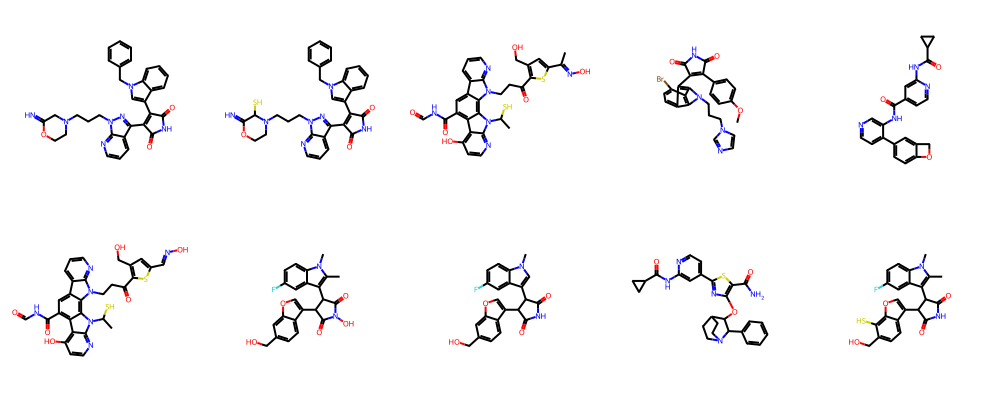

In [19]:
mols = filtered_df['molecule'].tolist()
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200))
display(img)